**CLOUD MASKING**
---

**Preface**
---

Satellite imagery is very useful for monitoring what is happening on earth surface. It has solved various problems, including wildfire related work.

However, we don't always have good imagery to begin with, some days are particularly cloudy. Which makes the problem even harder, we simply cannot see through it.

    + Even if some Machine Learning model predicts what is under the cloud, it is just pure inference, and I believe it has no value at all.

But, if it is still possible to enhance the details of data under "thin enough" cloud, it can be useful in lots of ways.

On the notebook. "cloud reduction", I have created a model to work on that idea. It is not perfect, one problem is the given cloud masking is not good enough.

    -> In this notebook, we will go over the analysis which is helpful for cloud masking. 

**Change dir**

In [1]:
import os

os.chdir('/home/bill/GitHub/wps-research/data/bill')

**Prepare Data**

In [2]:
from raster import Raster
from plot_tools import plot, plot_multiple
from misc import htrim_3d
import numpy as np
import joblib

We will be using 20m data for training and testing

In [3]:
img_1_fname = 'C11659/L1C/resampled_20m/S2A_MSIL1C_20250830T193831_N0511_R142_T09UYU_20250831T003315_20m.bin'
cloud_1_fname = 'C11659/cloud_20m/S2A_MSIL2A_20250830T193831_N0511_R142_T09UYU_20250831T011715_CLDPRB_20m.bin'

In [4]:
img_2_fname = 'C11659/L1C/resampled_20m/S2B_MSIL1C_20250902T192909_N0511_R142_T09UYU_20250902T230923_20m.bin'
cloud_2_fname = 'C11659/cloud_20m/S2B_MSIL2A_20250902T192909_N0511_R142_T09UYU_20250902T231719_CLDPRB_20m.bin'

In [5]:
img_1 = Raster(img_1_fname)
cloud_1 = Raster(cloud_1_fname)

img_2 = Raster(img_2_fname)
cloud_2 = Raster(cloud_2_fname)

In [6]:
img_1_dat = img_1.read_bands()
cloud_1_dat = cloud_1.read_bands().squeeze() / 100.

img_2_dat = img_2.read_bands()
cloud_2_dat = cloud_2.read_bands().squeeze() / 100.


for i, b in enumerate(img_1.band_info_list):
    print(f'{i}: {b}')

0: B12
1: B11
2: B09
3: B08


**Visualization**

In [7]:
from misc import htrim_3d

In [8]:
#Set lo, hi for agreement on trimming.
lo, hi = np.nanpercentile(img_1_dat, 1, axis=(0, 1)), np.nanpercentile(img_1_dat, 100 - 1, axis=(0, 1))

In [9]:
# plot_multiple(
#     [(img_1_dat - lo), htrim_3d(img_2_dat)],
#     title_list=['Pre Date', 'Post Date'],
#     max_per_row=2,
#     figsize=(15,8)
# )

**Differencing**

In [10]:
diff = (img_2_dat - img_1_dat) / (img_2_dat + img_1_dat + 1e-3)
relu_diff_negative = -diff * (diff < 0)
relu_diff_positive =  diff * (diff > 0)

In [11]:
X = np.dstack([diff, img_2_dat / 10000, img_1_dat / 10000]).reshape(-1, 12)

In [20]:
model = joblib.load('C11659/cloud_models/model_2025-08-20 19:19:09.024000.joblib')

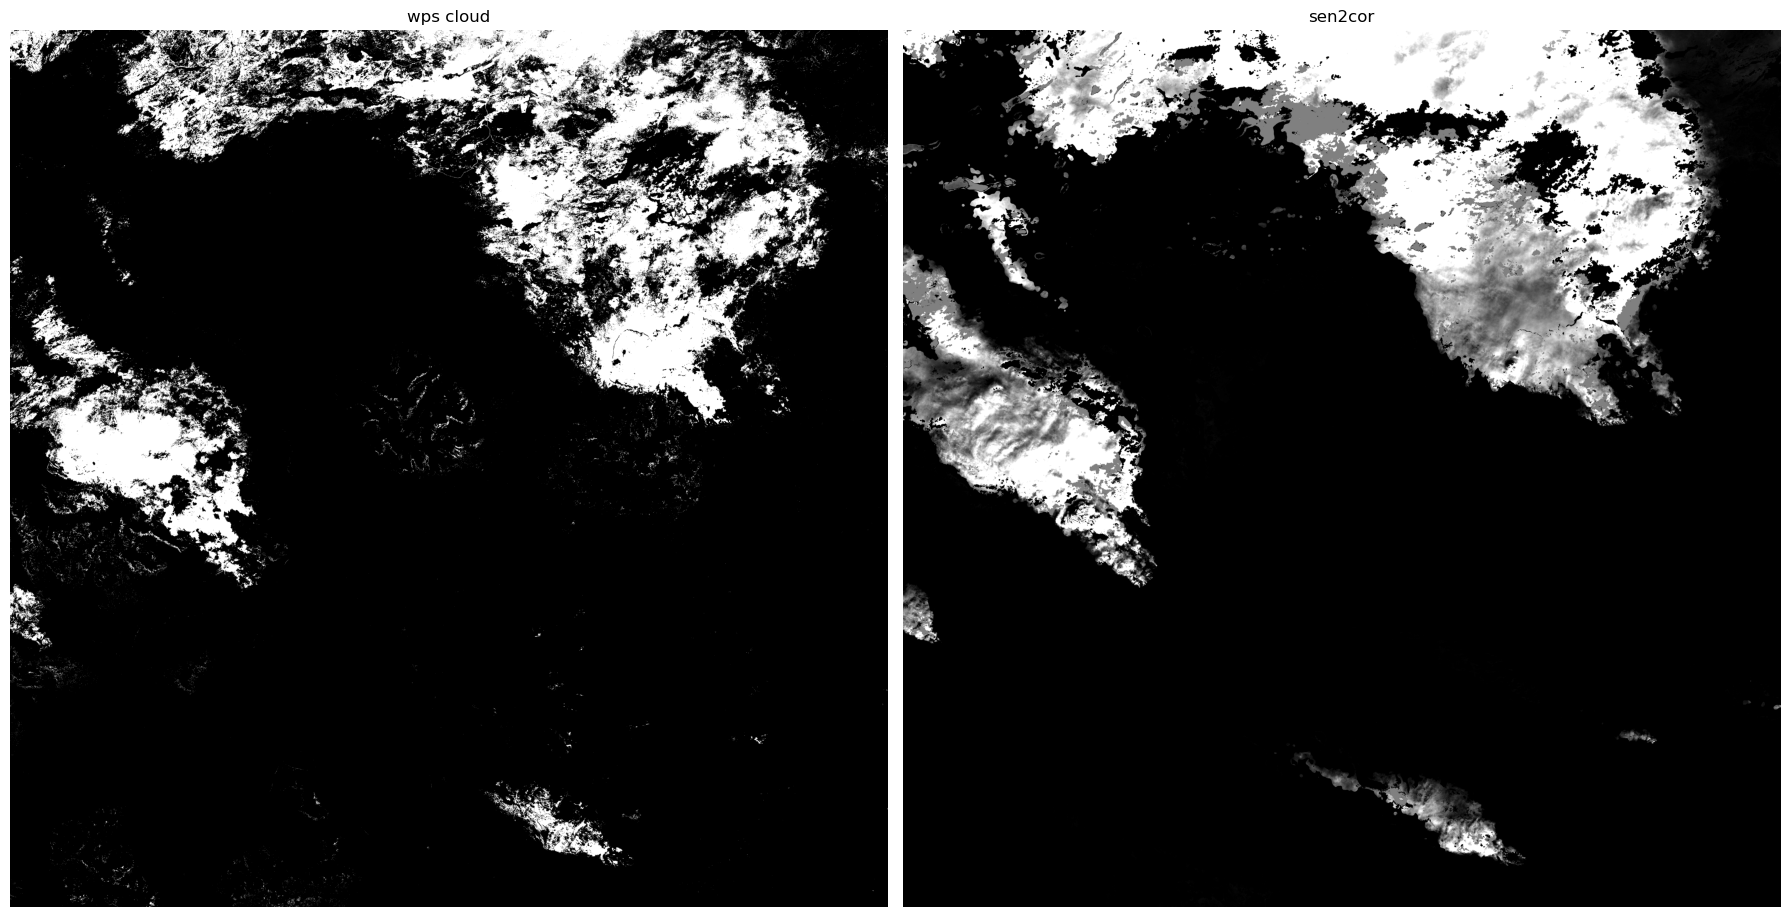

In [21]:
preds = model.predict(X)

mask = preds.reshape(cloud_2_dat.shape)

plot_multiple([mask, cloud_2_dat], title_list=['wps cloud', 'sen2cor'], max_per_row=2, figsize=(18, 10))